In [261]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from dataclasses import dataclass

In [262]:
os.getcwd()

'/Users/Christian/Desktop/MSMFT/Semester 2/Fixed Income/MF728-RiskAnalysisProject/Main Coding File'

In [263]:
data = pd.read_csv("../Data/CouponBonds/CouponBondData/YieldData/A Yield.csv", index_col = 0,header = list(range(8)))

data.sort_index(inplace = True)
data.index = pd.to_datetime(data.index)

data

,341099CH0 Corp,92976GAJ0 Corp,983024AN0 Corp,74456QAR7 Corp,207597DX0 Corp,771367BZ1 Corp,695114CG1 Corp,641423BU1 Corp,039483AX0 Corp,797440BJ2 Corp,...,92976GAJ0 Corp_20,695114CG1 Corp_21,695114CG1 Corp_22,207597DX0 Corp_23,87612EAR7 Corp,89417EAD1 Corp,695114CG1 Corp_26,207597DX0 Corp_27,141781AW4 Corp,171232AQ4 Corp
Company,Duke Energy Florida LLC,Wells Fargo Bank NA,Wyeth LLC,Public Service Electric and Gas Co,Connecticut Light and Power Co/The,Rochester Gas and Electric Corp,PacifiCorp,Nevada Power Co,Archer-Daniels-Midland Co,San Diego Gas & Electric Co,...,Wells Fargo Bank NA,PacifiCorp,PacifiCorp,Connecticut Light and Power Co/The,Target Corp,Travelers Cos Inc/The,PacifiCorp,Connecticut Light and Power Co/The,Cargill Inc,Chubb Corp/The
Ticker,DUK,WFC,PFE,PEG,ES,AGR,BRKHEC,BRKHEC,ADM,SRE,...,WFC,BRKHEC,BRKHEC,ES,TGT,TRV,BRKHEC,ES,CARGIL,CB
Rating,A,A,A,A,A,A,A,A,A,A,...,A,A,A,A,A,A,A,A,A,A
Issue Date,2007-09-18 00:00:00,2007-12-07 00:00:00,2007-03-27 00:00:00,2007-05-14 00:00:00,2007-03-27 00:00:00,2007-07-17 00:00:00,2007-10-03 00:00:00,2007-06-28 00:00:00,2007-12-11 00:00:00,2007-09-20 00:00:00,...,2007-12-07 00:00:00,2007-10-03 00:00:00,2007-10-03 00:00:00,2007-03-27 00:00:00,2007-10-05 00:00:00,2007-05-29 00:00:00,2007-10-03 00:00:00,2007-03-27 00:00:00,2007-09-11 00:00:00,2007-05-11 00:00:00
Maturity Date,2037-09-15 00:00:00,2038-01-15 00:00:00,2037-04-01 00:00:00,2037-05-01 00:00:00,2037-03-01 00:00:00,2032-07-15 00:00:00,2037-10-15 00:00:00,2037-07-01 00:00:00,2038-01-15 00:00:00,2037-09-15 00:00:00,...,2038-01-15 00:00:00,2037-10-15 00:00:00,2037-10-15 00:00:00,2037-03-01 00:00:00,2037-10-15 00:00:00,2037-06-15 00:00:00,2037-10-15 00:00:00,2037-03-01 00:00:00,2037-09-15 00:00:00,2037-05-11 00:00:00
Coupon,6.35,6.6,5.95,5.8,5.75,6.47,6.25,6.75,6.45,6.125,...,6.6,6.25,6.25,5.75,6.5,6.25,6.25,5.75,6.625,6
Tenor (days),10955,10997,10963,10945,10932,9130,10970,10961,10993,10953,...,10997,10970,10970,10932,10968,10975,10970,10932,10962,10958
2014-10-02,6.835,6.835,6.835,6.835,6.835,6.835,6.835,6.835,6.835,6.835,...,6.835,6.835,6.835,6.835,6.835,6.835,6.835,6.835,6.835,6.835
2014-10-03,6.865,6.865,6.865,6.865,6.865,6.865,6.865,6.865,6.865,6.865,...,6.865,6.865,6.865,6.865,6.865,6.865,6.865,6.865,6.865,6.865
2014-10-06,6.951,6.951,6.951,6.951,6.951,6.951,6.951,6.951,6.951,6.951,...,6.951,6.951,6.951,6.951,6.951,6.951,6.951,6.951,6.951,6.951


In [268]:
@dataclass
class CIR:
    """
    CIR model class that takes in a series of yields.
    """

    rates : pd.Series

    def __post_init__(self):
        """setting up the parameters for the CIR model"""

        self.rates, rates = self.rates/100, self.rates/100

        rt = rates[1:]

        #setting up the parameters for OLS regression
        delta_rt = rates.diff().dropna()
        sqrt_rt = np.sqrt(rt)
        delta_t = pd.Series(rates.index.to_series().diff().dropna().dt.days.values, index=delta_rt.index) / 360 * 12  # Ensure matching lengths
        T = (rates.index[-1] - rates.index[0]).days / 360 * 12  # Total time period in years

        #setting up the OLS regression
        y = delta_rt/sqrt_rt
        Y = np.array(y).reshape(-1, 1)

        x1 = delta_t/sqrt_rt
        x2 = sqrt_rt*delta_t

        X = np.array([x1, x2]).T

        # Fit the linear regression model
        model = LinearRegression(fit_intercept=False)
        model.fit(X, Y)

        # Extract the coefficients
        a, b = model.coef_[0]

        # Calculate the parameters
        kappa = -b
        theta = a/kappa
        sigma = np.sqrt(np.square(delta_rt/sqrt_rt).sum() / T)
        
        self.model = model
        self.theta = theta
        self.kappa = kappa
        self.sigma = sigma

    def simulate(self, N:int = 1, starting_rate:float = None) ->np.ndarray:
        """
        Simulate the CIR process using calibrated parameters.
        
        Parameters
        ----------
        N : int
            Number of simulations to run.
        starting_rate : float
            Starting interest rate for the simulation. If None, uses the first rate in the series.

        Returns
        -------
        np.ndarray
            Simulated interest rates. Each row corresponds to a simulation, and each column corresponds to a time step.
        """
        # Simulate the CIR process

        if starting_rate is None:
            starting_rate = self.rates.iloc[0]

        # Getting CIR parameters
        theta = self.theta
        kappa = self.kappa
        sigma = self.sigma
        delta_t = 1/360

        rates = np.zeros((N, len(self.rates)))

        for i in range(N):
            # Simulate the process
            # Use the CIR model parameters to generate future rates


            Z = np.random.normal(0, 1, size=(len(self.rates)))

            rates[i, :] = np.zeros(len(self.rates))
            rates[i, 0] = starting_rate

            for t in range(1, len(self.rates)):
                rates[i, t] = rates[i,t-1] + kappa * (theta - rates[i,t-1]) * delta_t + sigma * np.sqrt(delta_t) * np.sqrt(rates[i,t-1]) * Z[t-1]

        return rates
    

CIR(data.iloc[:,0]).simulate(100)

/var/folders/49/1jq9sd950fg6397s7sm972380000gn/T/ipykernel_31238/776976281.py:88: RuntimeWarning: invalid value encountered in sqrt
  rates[i, t] = rates[i,t-1] + kappa * (theta - rates[i,t-1]) * delta_t + sigma * np.sqrt(delta_t) * np.sqrt(rates[i,t-1]) * Z[t-1]


array([[0.06835   , 0.06828509, 0.06958287, ...,        nan,        nan,
               nan],
       [0.06835   , 0.06760507, 0.06746912, ..., 0.09667408, 0.09718202,
        0.09747941],
       [0.06835   , 0.06904157, 0.06909942, ...,        nan,        nan,
               nan],
       ...,
       [0.06835   , 0.06758794, 0.06732731, ..., 0.09572172, 0.09744046,
        0.09690459],
       [0.06835   , 0.06914685, 0.06944781, ..., 0.08180383, 0.08270507,
        0.08272021],
       [0.06835   , 0.06718007, 0.06804695, ...,        nan,        nan,
               nan]])

<Axes: >

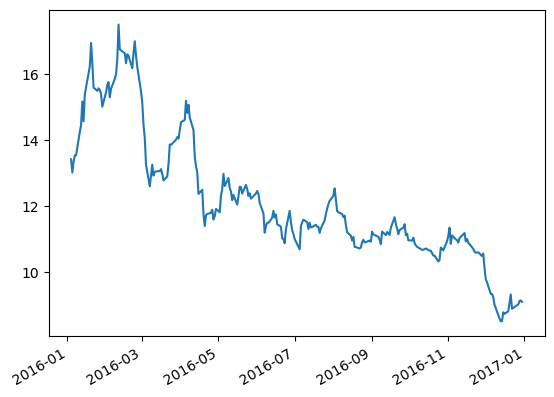

In [265]:
data.loc["2016-01-01":"2016-12-31"].iloc[:,2].plot()